[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_huggingface.ipynb)

## 0. Preparation

- Install latest version of SAHI and HuggingFace transformers:

In [ ]:
!pip install -U sahi
!pip install transformers timm

In [ ]:
import os
os.getcwd()

- Import required modules:

In [1]:
# import required functions, classes
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction
from sahi.utils.file import download_from_url
from sahi.utils.cv import read_image
from IPython.display import Image
import os

You can see object detection models available at [HF model hub](https://huggingface.co/models?pipeline_tag=object-detection&sort=downloads). We use smallest variant of RT-DETR v2 model for this demo.

In [5]:
# Select a model to use, we use a RD-DETRv2 model.
model_path = "PekingU/rtdetr_v2_r18vd" # larger models: PekingU/rtdetr_v2_r50vd, PekingU/rtdetr_v2_r101vd
os.environ["HF_TOKEN"] = "hf_..." # HF requires a token to download public models (no idea why)

# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

## 1. Standard Inference with HuggingFace RT-DETR v2 Model

- Instantiate a detection model by defining model weight path, config path and other parameters:

In [9]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='huggingface',
    model_path=model_path,
    confidence_threshold=0.5,
    image_size=640,
    device="cpu", # or 'cuda'
)

- Perform prediction by feeding the get_prediction function with an image path and a DetectionModel instance:

In [10]:
result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model)

- Or perform prediction by feeding the get_prediction function with a numpy image and a DetectionModel instance:

In [5]:
result = get_prediction(read_image("demo_data/small-vehicles1.jpeg"), detection_model)

- Visualize predicted bounding boxes and masks over the original image:

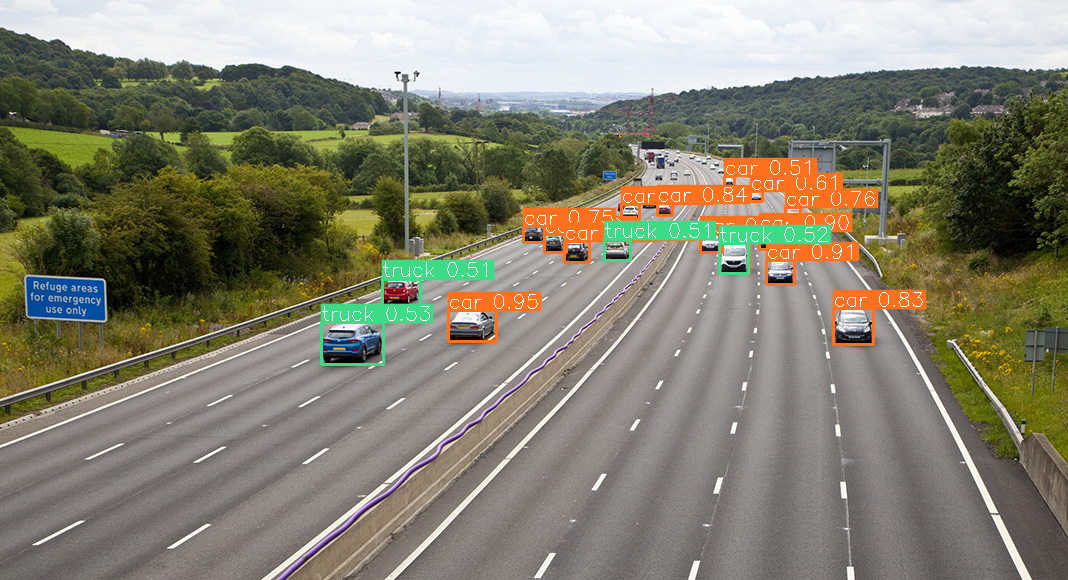

In [11]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 2. Sliced Inference with HuggingFace RT-DETR v2 Model

- To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 512x512 with an overlap ratio of 0.2:

In [12]:
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2,
)

Performing prediction on 6 slices.


- Visualize predicted bounding boxes and masks over the original image:

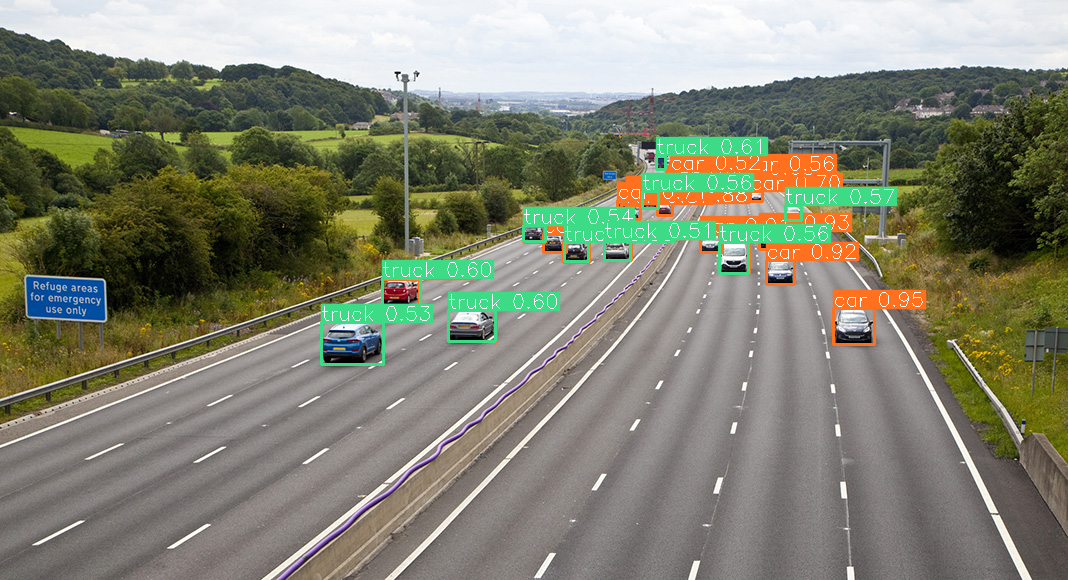

In [13]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 3. Prediction Result

- Predictions are returned as [sahi.prediction.PredictionResult](sahi/prediction.py), you can access the object prediction list as:

In [15]:
object_prediction_list = result.object_prediction_list

In [16]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(321, 322, 383, 364), w: 62, h: 42>,
    mask: None,
    score: PredictionScore: <value: 0.9695767164230347>,
    category: Category: <id: 2, name: car>>

In [17]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [321.0, 322.0, 62.0, 42.0],
  'score': 0.9695767164230347,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2604},
 {'image_id': None,
  'bbox': [448.0, 310.0, 48.0, 31.0],
  'score': 0.9618504047393799,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1488},
 {'image_id': None,
  'bbox': [833.0, 308.0, 41.0, 36.0],
  'score': 0.9468276500701904,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1476}]

- ObjectPrediction's can be converted to [COCO prediction](https://github.com/i008/COCO-dataset-explorer) format:

In [18]:
result.to_coco_predictions(image_id=1)[:3]

[{'image_id': 1,
  'bbox': [321.0, 322.0, 62.0, 42.0],
  'score': 0.9695767164230347,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2604},
 {'image_id': 1,
  'bbox': [448.0, 310.0, 48.0, 31.0],
  'score': 0.9618504047393799,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1488},
 {'image_id': 1,
  'bbox': [833.0, 308.0, 41.0, 36.0],
  'score': 0.9468276500701904,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1476}]

- ObjectPrediction's can be converted to [fiftyone](https://github.com/voxel51/fiftyone) detection format:

In [ ]:
!pip install fiftyone
result.to_fiftyone_detections()[:3]

- ObjectPrediction's can be converted to [imantics](https://github.com/jsbroks/imantics) annotation format:

In [12]:
!pip install -U imantics
result.to_imantics_annotations()[:3]

## 4. Batch Prediction

- Set model and directory parameters:

In [19]:
model_type = "huggingface"
model_path = model_path
model_device = "cpu" # or 'cuda:0'
model_confidence_threshold = 0.5

slice_height = 512
slice_width = 512
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

source_image_dir = "demo_data/"

- Perform sliced inference on given folder:

In [21]:
predict(
    model_type=model_type,
    model_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 4 listed files in folder: demo_data/


Performing inference on images:   0%|          | 0/4 [00:00<?, ?it/s]

Performing prediction on 15 slices.


Performing inference on images:  25%|██▌       | 1/4 [00:01<00:03,  1.08s/it]

Prediction time is: 990.94 ms
Performing prediction on 6 slices.


Performing inference on images:  50%|█████     | 2/4 [00:01<00:01,  1.37it/s]

Prediction time is: 436.86 ms
Performing prediction on 6 slices.


Performing inference on images:  75%|███████▌  | 3/4 [00:02<00:00,  1.60it/s]

Prediction time is: 460.08 ms
Performing prediction on 6 slices.


Performing inference on images: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

Prediction time is: 456.77 ms
Prediction results are successfully exported to runs\predict\exp6
